In [1]:
import  logging

def configure_logger():
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)

# Loading Data

In [4]:
import os 

import numpy as np
import pandas as pd

In [5]:
# !mkdir ../../mary-data

In [6]:
# !gsutil -m rsync -r gs://elvos/processed/luke1/ ../../mary-data

In [7]:
# !ls ../../mary-data

# Preprocessing

In [8]:
LENGTH, WIDTH, HEIGHT = (160, 160, 50)

VALID_TRAINING_INDICES = []
VALID_VALIDATION_INDICES = []

def load_training_data() -> np.array:
    """Returns 4D matri x of training data
    Data is in the form (n_samples, 1, w, h). 
    Samples are sorted by patient ID"""
    arrays = []
    training_filenames = sorted(os.listdir(
        '/home/mdong5/mary-data/training/'))
    for i, filename in enumerate(training_filenames):
        arr = np.load('/home/mdong5/mary-data/training/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_TRAINING_INDICES.append(i)
        else:
            logging.info(
                f'training file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)

def load_validation_data() -> np.array:
    """Returns 4D matri x of validation data
    Data is in the form (n_samples, 1, w, h). 
    Samples are sorted by patient ID"""
    
    arrays = []
    validation_filenames = sorted(os.listdir(
        '/home/mdong5/mary-data/validation/'))
    for i, filename in enumerate(validation_filenames):
        arr = np.load('/home/mdong5/mary-data/validation/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_VALIDATION_INDICES.append(i)
        else:
            logging.info(
                f'training file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)

def load_labels() -> (np.array, np.array):
    training_df = pd.read_csv('/home/mdong5/mary-data/training_labels.csv')
    validation_df = pd.read_csv('/home/mdong5/mary-data/validation_labels.csv')
    training_labels = training_df.sort_values('patient_id')['label'].values
    validation_labels = validation_df.sort_values('patient_id')['label'].values
    return training_labels, validation_labels

In [9]:
VALID_TRAINING_INDICES = []
VALID_VALIDATION_INDICES = []

X_train = load_training_data()
X_valid = load_validation_data()
y_train, y_valid = load_labels()
y_train = y_train[VALID_TRAINING_INDICES]
y_valid = y_valid[VALID_VALIDATION_INDICES]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(500, 160, 160, 50) (500,) (378, 160, 160, 50) (378,)


In [10]:
def squash_height(X: np.array):
    return X.max(axis=3)

In [25]:
X_train_squashed = squash_height(X_train)
X_train = np.stack([X_train_squashed, X_train_squashed, X_train_squashed], axis=3)
print(X_train.shape)

X_valid_squashed = squash_height(X_valid)
X_valid = np.stack([X_valid_squashed, X_valid_squashed, X_valid_squashed], axis=3)
print(X_valid.shape)

(500, 160, 160, 3)
(378, 160, 160, 3)


# Exploration

In [26]:
%matplotlib inline

In [27]:
print(X_train.shape, X_train.min(), X_train.max())

(500, 160, 160, 3) 0.0 1.0


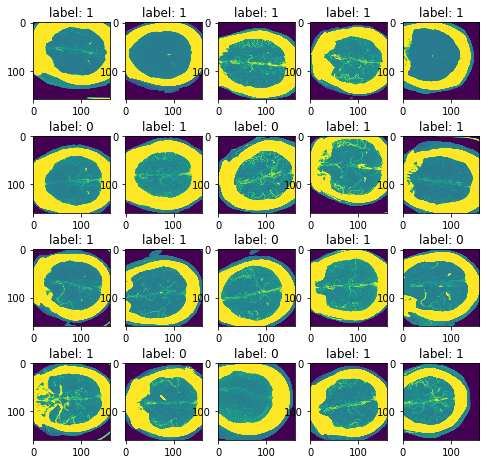

In [28]:
import matplotlib.pyplot as plt

ROWS = 4
COLS = 5
OFFSET = 40
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(ROWS, COLS, i + 1)
    ax.set_title(f'label: {y_train[i + OFFSET]}')
    plt.imshow(X_train_squashed[i + OFFSET])

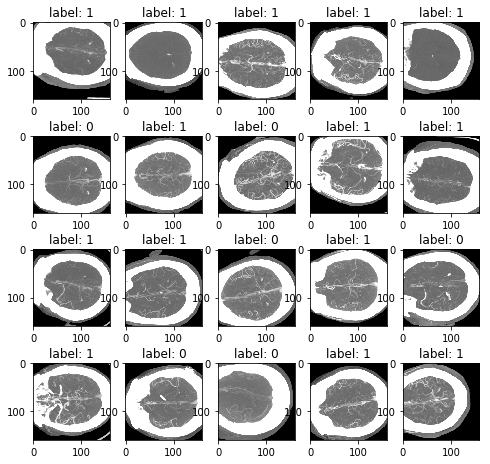

In [29]:
ROWS = 4
COLS = 5
OFFSET = 40
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(ROWS, COLS, i + 1)
    ax.set_title(f'label: {y_train[i + OFFSET]}')
    plt.imshow(X_train[i + OFFSET])

# Data Augmentation

In [30]:
X_train_flipped = np.flip(X_train, 1)

augmented_X_train = np.concatenate([X_train, X_train_flipped], axis=0)
augmented_y_train = np.concatenate([y_train, y_train], axis=0)

In [32]:
print(augmented_X_train.shape)
print(augmented_y_train.shape)

(1000, 160, 160, 3)
(1000,)


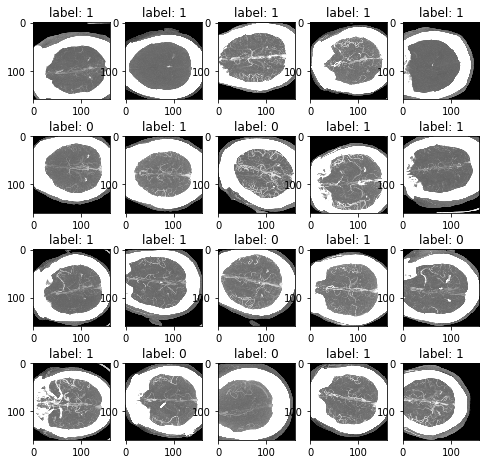

In [33]:
ROWS = 4
COLS = 5
OFFSET = 40
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(ROWS, COLS, i + 1)
    ax.set_title(f'label: {y_train[i + OFFSET]}')
    plt.imshow(X_train_flipped[i + OFFSET])

# Building Model

In [45]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.models import Model
from keras.optimizers import Adam

# expected input shape: (160, 160, 3)
# base_model = applications.nasnet.NASNetMobile(input_shape=(160, 160, 3), include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
base_model = applications.mobilenet.MobileNet(input_shape=(160, 160, 3), alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

17227776/17225924 [==============================] - 1s 0us/step


ResourceExhaustedError: OOM when allocating tensor with shape[1,1,512,512]
	 [[Node: conv_pw_11/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6047525, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv_pw_7/random_uniform/shape)]]

Caused by op 'conv_pw_11/random_uniform/RandomUniform', defined at:
  File "/local/projects/python3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/local/projects/python3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/local/projects/python3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/local/projects/python3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/local/projects/python3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-1aab0fdec1f7>", line 11, in <module>
    base_model = applications.mobilenet.MobileNet(input_shape=(160, 160, 3), alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras_applications/mobilenet.py", line 266, in MobileNet
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras_applications/mobilenet.py", line 469, in _depthwise_conv_block
    name='conv_pw_%d' % block_id)(x)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras/engine/base_layer.py", line 432, in __call__
    self.build(input_shapes[0])
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras/layers/convolutional.py", line 138, in build
    constraint=self.kernel_constraint)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras/engine/base_layer.py", line 249, in add_weight
    weight = K.variable(initializer(shape),
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras/initializers.py", line 218, in __call__
    dtype=dtype, seed=self.seed)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 4077, in random_uniform
    dtype=dtype, seed=seed)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 473, in _random_uniform
    name=name)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/gpfs/main/home/mdong5/elvo-analysis/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,1,512,512]
	 [[Node: conv_pw_11/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6047525, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv_pw_7/random_uniform/shape)]]


In [ ]:
# build a classifier model to put on top of the convolutional model
# This consists of a global average pooling layer and a fully connected layer with 256 nodes # Then apply dropout and sigmoid activation
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))
model = Model(inputs=base_model.input, outputs=model_top(base_model.output))
# Compile model using Adam optimizer with common values and binary cross entropy loss # Use low learning rate (lr) for transfer learning
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# epochs = number of passes of through training data # batch_size = number images processed at same time train_samples = 65

epochs = 20
batch_size = 32

In [32]:
# Fine-tune the pretrained Inception V3 model using the data generator 
# Specify steps per epoch (number of samples/batch_size)
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid))

Train on 500 samples, validate on 378 samples
Epoch 1/10
500/500 [==============================] - 37s 74ms/step - loss: 0.7775 - acc: 0.5080 - val_loss: 0.6955 - val_acc: 0.5212
Epoch 2/10
500/500 [==============================] - 9s 18ms/step - loss: 0.7419 - acc: 0.5080 - val_loss: 0.6790 - val_acc: 0.5608
Epoch 3/10
500/500 [==============================] - 9s 18ms/step - loss: 0.7169 - acc: 0.5440 - val_loss: 0.6714 - val_acc: 0.5688
Epoch 4/10
500/500 [==============================] - 9s 18ms/step - loss: 0.7058 - acc: 0.5720 - val_loss: 0.6692 - val_acc: 0.5688
Epoch 5/10
500/500 [==============================] - 9s 18ms/step - loss: 0.6864 - acc: 0.5680 - val_loss: 0.6689 - val_acc: 0.5767
Epoch 6/10
500/500 [==============================] - 9s 18ms/step - loss: 0.6597 - acc: 0.6120 - val_loss: 0.6695 - val_acc: 0.5873
Epoch 7/10
500/500 [==============================] - 9s 18ms/step - loss: 0.6490 - acc: 0.6200 - val_loss: 0.6638 - val_acc: 0.5635
Epoch 8/10
500/500 [==

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


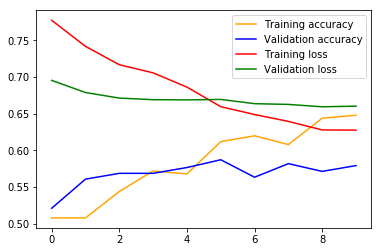

In [33]:
# import matplotlib library, and plot training cuve
import matplotlib.pyplot as plt 
print(history.history.keys())
plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy') 
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy') 
plt.plot(history.history['loss'], 'red', label='Training loss') 
plt.plot(history.history['val_loss'], 'green', label='Validation loss') 
plt.legend()
plt.show()

In [34]:
model.save('model-inception-06-12-18')